In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Load the CSV files
train_data = pd.read_csv('train_data.csv', header=None)
train_label = pd.read_csv('train_label.csv', header=None)
val_data = pd.read_csv('val_data.csv', header=None)
val_label = pd.read_csv('val_label.csv', header=None)
test_data = pd.read_csv('test_data.csv', header=None)
test_label = pd.read_csv('test_label.csv', header=None)

# Print the dataset shapes to verify dimensions
print(f'Original Train data shape: {train_data.shape}')
print(f'Original Val data shape: {val_data.shape}')
print(f'Original Test data shape: {test_data.shape}')

# Ensure that the number of features is 36 (expected size)
assert train_data.shape[1] == 36, "Train data does not have 36 features"
assert val_data.shape[1] == 36, "Val data does not have 36 features"
assert test_data.shape[1] == 36, "Test data does not have 36 features"

Original Train data shape: (2100, 36)
Original Val data shape: (300, 36)
Original Test data shape: (600, 36)


In [ ]:
# Min-Max Normalization
scaler = MinMaxScaler()

train_data_normalized = scaler.fit_transform(train_data)
val_data_normalized = scaler.transform(val_data)
test_data_normalized = scaler.transform(test_data)

# Convert to tensors
train_data_tensor = torch.tensor(train_data_normalized, dtype=torch.float32)
train_label_tensor = torch.tensor(train_label.values.flatten(), dtype=torch.long)

val_data_tensor = torch.tensor(val_data_normalized, dtype=torch.float32)
val_label_tensor = torch.tensor(val_label.values.flatten(), dtype=torch.long)

test_data_tensor = torch.tensor(test_data_normalized, dtype=torch.float32)
test_label_tensor = torch.tensor(test_label.values.flatten(), dtype=torch.long)

# Print tensor shapes to verify
print(f'Train data tensor shape: {train_data_tensor.shape}')
print(f'Val data tensor shape: {val_data_tensor.shape}')
print(f'Test data tensor shape: {test_data_tensor.shape}')

Train data tensor shape: torch.Size([2100, 36])
Val data tensor shape: torch.Size([300, 36])
Test data tensor shape: torch.Size([600, 36])


In [ ]:
# Dataset and DataLoader
batch_size = 32
train_dataset = TensorDataset(train_data_tensor, train_label_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(val_data_tensor, val_label_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = TensorDataset(test_data_tensor, test_label_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Define the MLFFNN model
class MLFFNN(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size):
        super(MLFFNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.fc3 = nn.Linear(hidden2_size, output_size)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))  # Tanh activation for hidden layers
        x = torch.tanh(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)  # Softmax activation for output layer
        return x

In [ ]:
# Instantiate the model
input_size = 36  # Number of input features
hidden1_size = 25
hidden2_size = 15
output_size = 5  # Assuming 5 classes in the dataset
model = MLFFNN(input_size, hidden1_size, hidden2_size, output_size)

In [ ]:
# Define hyperparameters
learning_rate = 0.07
momentum = 0.9
threshold = 0.0001  # Convergence criterion on average error

In [ ]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

In [ ]:
# Training function
def train_model(model, train_loader, optimizer, criterion, num_epochs=500):
    model.train()
    loss_list = []
    epoch_list = []

    for epoch in range(num_epochs):
        epoch_loss = 0
        for data, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        loss_list.append(avg_loss)
        epoch_list.append(epoch)

        # Early stopping based on the change in average error
        if epoch > 0 and abs(loss_list[-1] - loss_list[-2]) < threshold:
            print(f"Converged after {epoch} epochs")
            break

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

    # Plot Training Error
    plot_training_error(epoch_list, loss_list)

In [ ]:
# Plot function for training error
def plot_training_error(epochs, losses):
    plt.figure(figsize=(8,6))
    plt.plot(epochs, losses, label="Training Error")
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.title('Training Error (ξav) vs Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

Epoch [1/500], Loss: 1.6090
Epoch [2/500], Loss: 1.5997
Epoch [3/500], Loss: 1.5673
Epoch [4/500], Loss: 1.5330
Epoch [5/500], Loss: 1.5143
Epoch [6/500], Loss: 1.4826
Epoch [7/500], Loss: 1.4625
Epoch [8/500], Loss: 1.4392
Epoch [9/500], Loss: 1.4384
Epoch [10/500], Loss: 1.4244
Epoch [11/500], Loss: 1.4234
Epoch [12/500], Loss: 1.4232
Epoch [13/500], Loss: 1.4188
Epoch [14/500], Loss: 1.4052
Epoch [15/500], Loss: 1.3927
Epoch [16/500], Loss: 1.3990
Epoch [17/500], Loss: 1.3996
Epoch [18/500], Loss: 1.3862
Epoch [19/500], Loss: 1.3839
Epoch [20/500], Loss: 1.3861
Epoch [21/500], Loss: 1.3839
Epoch [22/500], Loss: 1.3932
Epoch [23/500], Loss: 1.3763
Epoch [24/500], Loss: 1.3862
Epoch [25/500], Loss: 1.3941
Epoch [26/500], Loss: 1.3872
Epoch [27/500], Loss: 1.3883
Epoch [28/500], Loss: 1.3666
Epoch [29/500], Loss: 1.3716
Epoch [30/500], Loss: 1.3635
Epoch [31/500], Loss: 1.3601
Epoch [32/500], Loss: 1.3658
Epoch [33/500], Loss: 1.3679
Epoch [34/500], Loss: 1.3554
Epoch [35/500], Loss: 1

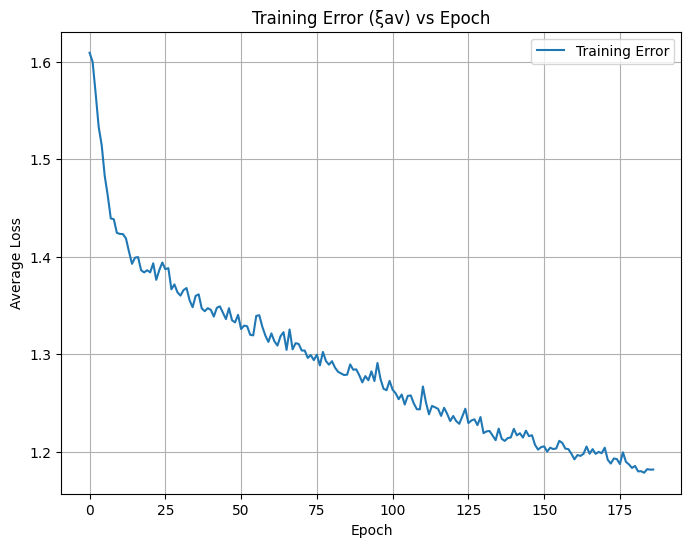

In [ ]:
# Train the model
train_model(model, train_loader, optimizer, criterion)

In [ ]:
# Validation and Test functions to evaluate the model
def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, labels in data_loader:
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total * 100
    return accuracy

In [ ]:
# Evaluate on validation and test datasets
val_accuracy = evaluate_model(model, val_loader)
test_accuracy = evaluate_model(model, test_loader)
train_accuracy = evaluate_model(model, train_loader)

print(f'Validation Accuracy: {val_accuracy:.2f}%')
print(f'Test Accuracy: {test_accuracy:.2f}%')
print(f'Train Accuracy: {train_accuracy:.2f}%')

Validation Accuracy: 48.00%
Test Accuracy: 49.67%
Train Accuracy: 72.95%
